In [ ]:
! pip install kaggle

In [1]:
! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
^C


In [2]:
import zipfile
with zipfile.ZipFile('gtzan-dataset-music-genre-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('GTZAN')

KeyboardInterrupt: 

In [3]:
import pandas as pd
df = pd.read_csv('GTZAN/Data/features_30_sec.csv')

In [4]:
len(df['label'].unique())

10

Detectting the most important features using Random Forest

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, 1:-1].values  # Features
y = df["label"].values  # Genre labels

In [6]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

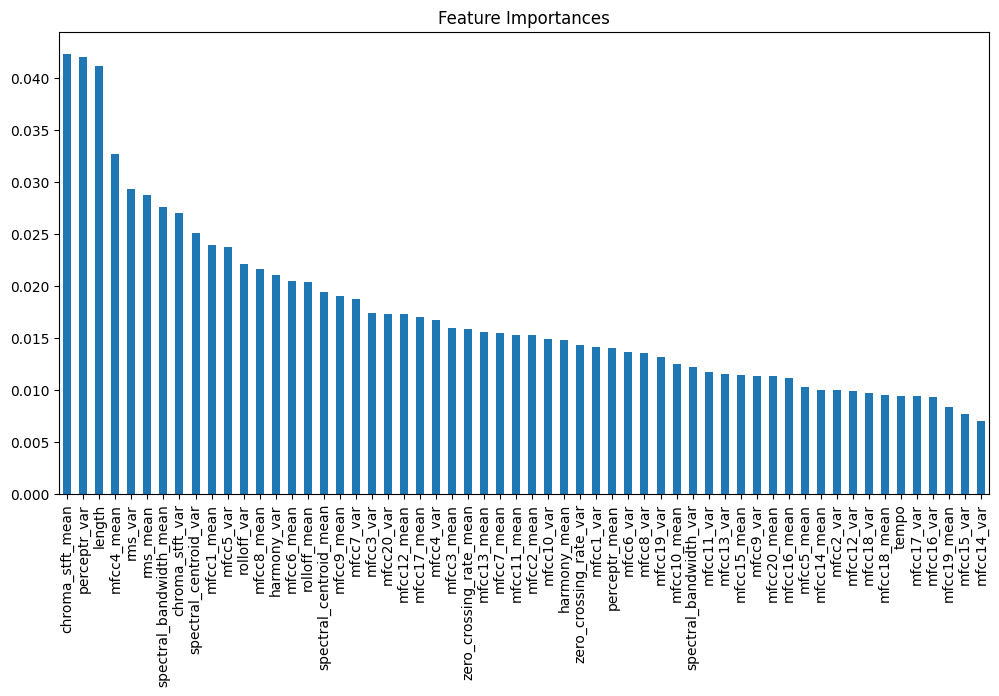

In [7]:
feature_importances = pd.Series(rf.feature_importances_, index=df.columns[1:-1])
feature_importances.sort_values(ascending=False, inplace=True)
feature_importances.plot(kind='bar', figsize=(12, 6), title='Feature Importances');

Feature Scaling

In [8]:
#Standardize features
X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)
#Normalize features
X_normalized = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

Maybe delete fetures below 0.015

In [9]:
import numpy as np
from collections import Counter

def euclidean_distance(x1, x2):
    return np.sqrt((np.sum(x1-x2))**2)

class KNN:
    def __init__(self, k=11):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict_all(self, X_test):
        return [self.predict(x) for x in X_test]
    
    def predict(self, x):
        distance = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_index = np.argsort(distance)[:self.k]
        k_labels = [self.y_train[i] for i in k_index]
        winner = Counter(list(k_labels)).most_common(1)
        return winner[0][0]

In [10]:
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [11]:
knn = KNN()

In [12]:
knn.fit(X_train, y_train)

In [13]:
y = knn.predict_all(X_test)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y, zero_division=0))

              precision    recall  f1-score   support

       blues       0.37      0.35      0.36        20
   classical       0.16      0.23      0.19        13
     country       0.21      0.15      0.17        27
       disco       0.14      0.19      0.16        21
      hiphop       0.27      0.40      0.32        15
        jazz       0.33      0.27      0.30        22
       metal       0.17      0.12      0.14        25
         pop       0.25      0.31      0.28        13
      reggae       0.17      0.17      0.17        23
        rock       0.12      0.10      0.11        21

    accuracy                           0.21       200
   macro avg       0.22      0.23      0.22       200
weighted avg       0.22      0.21      0.21       200



In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

class NaiveBayes:
    def __init__(self, distr='Gaussian'):
        self.distr = distr
    
    def get_stats(self, x):
        return x.mean(), np.std(x)
    
    def pdf(self, X, mean, sigma):
        power = -0.5 * ((X - mean) / sigma) ** 2
        return np.exp(power) / (sigma * np.sqrt(2 * np.pi))

    def fit(self, X_train, y_train):
        # Encode string labels to integers
        self.encoder = LabelEncoder()
        y_encoded = self.encoder.fit_transform(y_train)
        
        self.classes = np.unique(y_encoded)
        class_counts = np.bincount(y_encoded)
        self.full_stats = {}
        
        for i, cls in enumerate(self.classes):
            p_apriori = class_counts[i] / len(y_encoded)
            infos = {'apriori': p_apriori, 'stats': []}
            X_class = X_train[y_encoded == cls]
            
            for j in range(X_class.shape[1]):
                X_col = X_class[:, j]
                infos['stats'].append(self.get_stats(X_col))
            
            self.full_stats[cls] = infos

    def predict_proba(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.full_stats)
        log_probs = np.zeros((n_samples, n_classes))
        
        for idx, (cls, info) in enumerate(self.full_stats.items()):
            log_p = np.log(info['apriori'])
            for i, (mean, stdev) in enumerate(info['stats']):
                stdev = max(stdev, 1e-6)  # Avoid division by zero
                log_p += np.log(self.pdf(X[:, i], mean, stdev))
            log_probs[:, idx] = log_p
        
        # Optional: return normalized probabilities
        probs = np.exp(log_probs - log_probs.max(axis=1, keepdims=True))  # prevent overflow
        probs /= probs.sum(axis=1, keepdims=True)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        predictions = np.argmax(probs, axis=1)
        return self.encoder.inverse_transform(predictions)


In [28]:
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [29]:
nb = NaiveBayes()

In [33]:
nb.fit(X_train, y_train)

In [34]:
y = nb.predict(X_test)

/var/folders/33/6t1xnkrd2tbb5n7q452xfbgc0000gn/T/ipykernel_81252/2154994765.py:45: RuntimeWarning: divide by zero encountered in log
  log_p += np.log(self.pdf(X[:, i], mean, stdev))


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y, zero_division=0))

              precision    recall  f1-score   support

       blues       0.24      0.70      0.36        20
   classical       0.92      0.92      0.92        13
     country       0.60      0.22      0.32        27
       disco       0.60      0.43      0.50        21
      hiphop       0.53      0.60      0.56        15
        jazz       0.67      0.27      0.39        22
       metal       0.53      0.96      0.69        25
         pop       0.82      0.69      0.75        13
      reggae       0.50      0.26      0.34        23
        rock       0.40      0.19      0.26        21

    accuracy                           0.49       200
   macro avg       0.58      0.53      0.51       200
weighted avg       0.56      0.49      0.48       200



Logistics Regression

In [60]:
class LogisticRegression:
    def __init__(self, lr=0.1, max_iter=1000, tol=1e-4):
        """
        Logistic Regression Classifier.

        Parameters:
        lr (float): Learning rate for gradient descent.
        max_iter (int): Maximum number of iterations for optimization.
        tol (float): Tolerance for stopping criteria.
        """
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol

    def sigmoid(self, z):
        """
        Compute the sigmoid function.

        Parameters:
        z (numpy.ndarray): Input array.

        Returns:
        numpy.ndarray: Sigmoid of the input.
        """
        return 1 / (1 + np.exp(-z))

    def loss_function(self, X, y):
        """
        Compute the binary cross-entropy loss.

        Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): True labels.

        Returns:
        float: Loss value.
        """
        p = self.sigmoid(np.dot(X, self.w))
        return -np.mean(y * np.log(p + 1e-9) + (1 - y) * np.log(1 - p + 1e-9))

    def gradient(self, X, y):
        """
        Compute the gradient of the loss function.

        Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): True labels.

        Returns:
        numpy.ndarray: Gradient vector.
        """
        p = self.sigmoid(np.dot(X, self.w))
        return np.dot(X.T, (p - y)) / X.shape[0]

    def fit(self, X, y):
        """
        Fit the logistic regression model.

        Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): True labels.

        Returns:
        None
        """
        # Add bias term (intercept) to the feature matrix
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.w = np.random.randn(X.shape[1])  # Initialize weights randomly

        for _ in range(self.max_iter):
            grad = self.gradient(X, y)
            if np.linalg.norm(grad) < self.tol:
                break
            self.w -= self.lr * grad

    def predict_proba(self, X):
        """
        Predict probabilities for the positive class.

        Parameters:
        X (numpy.ndarray): Feature matrix.

        Returns:
        numpy.ndarray: Predicted probabilities.
        """
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return self.sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold=0.5):
        """
        Predict class labels.

        Parameters:
        X (numpy.ndarray): Feature matrix.
        threshold (float): Decision threshold.

        Returns:
        numpy.ndarray: Predicted class labels.
        """
        probas = self.predict_proba(X)
        return (probas >= threshold).astype(int)

In [57]:
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [58]:
lr = LogisticRegression()

In [65]:
lr.fit(X_train, y_train)
y = lr.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y, zero_division=0))

              precision    recall  f1-score   support

       blues       0.23      0.40      0.29        20
   classical       0.80      0.92      0.86        13
     country       0.22      0.07      0.11        27
       disco       0.36      0.38      0.37        21
      hiphop       0.44      0.53      0.48        15
        jazz       0.56      0.41      0.47        22
       metal       0.53      0.76      0.62        25
         pop       0.36      0.69      0.47        13
      reggae       0.62      0.35      0.44        23
        rock       0.36      0.19      0.25        21

    accuracy                           0.43       200
   macro avg       0.45      0.47      0.44       200
weighted avg       0.44      0.43      0.41       200



SVM

In [84]:
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [87]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize the SVM classifier with a linear kernel
svm = SVC(kernel='poly', C=1, random_state=42)

# Fit the SVM model to the training data
svm.fit(X_train, y_train)

# Predict the labels for the test data
y_pred_svm = svm.predict(X_test)

# Evaluate the SVM model
print(classification_report(y_test, y_pred_svm, zero_division=0))

              precision    recall  f1-score   support

       blues       0.59      0.85      0.69        20
   classical       1.00      0.92      0.96        13
     country       0.71      0.63      0.67        27
       disco       0.60      0.57      0.59        21
      hiphop       0.55      0.80      0.65        15
        jazz       0.91      0.91      0.91        22
       metal       0.92      0.92      0.92        25
         pop       0.90      0.69      0.78        13
      reggae       0.80      0.35      0.48        23
        rock       0.54      0.67      0.60        21

    accuracy                           0.72       200
   macro avg       0.75      0.73      0.72       200
weighted avg       0.75      0.72      0.72       200



LDA

In [88]:
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report

lda = LDA()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print(classification_report(y_test, y_pred_lda, zero_division=0))

              precision    recall  f1-score   support

       blues       0.56      0.45      0.50        20
   classical       1.00      0.92      0.96        13
     country       0.71      0.63      0.67        27
       disco       0.57      0.76      0.65        21
      hiphop       0.80      0.80      0.80        15
        jazz       0.83      0.86      0.84        22
       metal       0.88      0.88      0.88        25
         pop       0.77      0.77      0.77        13
      reggae       0.64      0.39      0.49        23
        rock       0.33      0.48      0.39        21

    accuracy                           0.68       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.70      0.68      0.68       200



QDA

In [96]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import classification_report

qda = QDA(reg_param=1)
qda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print(classification_report(y_test, y_pred_lda, zero_division=0))

              precision    recall  f1-score   support

       blues       0.56      0.45      0.50        20
   classical       1.00      0.92      0.96        13
     country       0.71      0.63      0.67        27
       disco       0.57      0.76      0.65        21
      hiphop       0.80      0.80      0.80        15
        jazz       0.83      0.86      0.84        22
       metal       0.88      0.88      0.88        25
         pop       0.77      0.77      0.77        13
      reggae       0.64      0.39      0.49        23
        rock       0.33      0.48      0.39        21

    accuracy                           0.68       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.70      0.68      0.68       200

